In [1]:
import numpy as np
import scipy.io as sio
%matplotlib notebook
import os
import h5py
import sklearn.linear_model as slm
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.ndimage.filters as sfi
import pyute as ut
from oasis.functions import deconvolve
import scipy.stats as sst

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
# resultfile = '/home/mossing/scratch/2Pdata/suite2P/results/M7194/170808/0/expt.mat'
# matfile = sio.loadmat(resultfile)
roibase = '/home/mossing/scratch/2Pdata/180327/M8570/ot/M8570_151_002_ot_00'
roifiles = [roibase+str(i)+'.rois' for i in range(1,4)]
# roifile = '/home/mossing/excitation/2P/170808/M7194/ot/M7194_999_000_ot_000.rois'
infofile = '/home/mossing/scratch/2Pdata/180327/M8570/ot/M8570_151_002_ot_000.mat'
resultfile = '/home/mossing/excitation/visual_stim/180327/M8570/M8570_151_002.mat'
traces = np.array(())
for roifile in roifiles:
    with h5py.File(roifile,mode='r') as f:
        if traces.size:
            print(f['corrected'][()].T.shape)
            try:
                traces = np.concatenate((traces,f['corrected'][()].T),axis=0)
            except:
                to_add = f['corrected'][()].T
                to_add = np.concatenate((to_add,np.zeros((to_add.shape[0],1))),axis=1)
                traces = np.concatenate((traces,to_add),axis=0)
        else:
            print(f['corrected'][()].T.shape)
            traces = f['corrected'][()].T
#     trialwise = f['trialwise'][()].T
frame = sio.loadmat(infofile, squeeze_me=True)['info'][()]['frame']
stimParams = sio.loadmat(resultfile, squeeze_me=True)['result'][()]['stimParams']

(193, 9510)
(247, 9510)
(211, 9510)


In [3]:
thisfold = '180327/M8570/'
thisfile = 'M8570_151_002'

datafoldbase = '/home/mossing/scratch/2Pdata/'
datafold = datafoldbase+thisfold+'ot/'
datafiles = [thisfile+'_ot_'+number+'.rois' for number in ['001','002','003']]

stimfoldbase = '/home/mossing/excitation/visual_stim/'
stimfold = stimfoldbase+thisfold
stimfile = thisfile+'.mat'

In [4]:
blcutoff = 10
ds = 10
blspan = 3000
nbefore = 0
nafter = 0
def gen_trialwise(nbefore=nbefore,nafter=nafter,blcutoff=blcutoff,blspan=blspan):
    trialwise = np.array(())
    ctrialwise = np.array(())
    strialwise = np.array(())
    try:
        for datafile in datafiles:
            frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][:]
            to_add = sio.loadmat(datafold+datafile,squeeze_me=True)['corrected']
    #         baseline = np.percentile(to_add,blcutoff,axis=1)
            baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
            baseline = np.repeat(baseline,ds,axis=1)
    #         if baseline.shape[1]<to_add.shape[1]:
    #             baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
            if baseline.shape[1]>to_add.shape[1]:
                baseline = baseline[:,:to_add.shape[1]]
            c = np.zeros_like(to_add)
            s = np.zeros_like(to_add)
            for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
            to_add = ut.trialize(to_add,frm,nbefore,nafter)
            c = ut.trialize(c,frm,nbefore,nafter)
            s = ut.trialize(s,frm,nbefore,nafter)
            try:
                trialwise = np.concatenate((trialwise,to_add),axis=0)
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
            except:
                trialwise = to_add.copy()
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
    except:
        for datafile in datafiles:
            frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][:]
            rg = np.concatenate((np.arange(1,991),np.arange(992,frm.shape[0])))
            frm = frm[rg]
            with h5py.File(datafold+datafile,mode='r') as f:
                to_add = f['corrected'][:].T
    #             baseline = np.percentile(to_add,blcutoff,axis=1)
                baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
                baseline = np.repeat(baseline,ds,axis=1)
    #             if baseline.shape[1]<to_add.shape[1]:
    #                 baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
                if baseline.shape[1]>to_add.shape[1]:
                    baseline = baseline[:,:to_add.shape[1]]
                c = np.zeros_like(to_add)
                s = np.zeros_like(to_add)
                to_add[np.isnan(to_add)] = 0
                for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                    dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                    print(dfof.min())
                    try:
                        c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
                    except:
                        print("in "+datafile+" couldn't do "+str(i))
                to_add = ut.trialize(to_add,frm,nbefore,nafter)
                c = ut.trialize(c,frm,nbefore,nafter)
                s = ut.trialize(s,frm,nbefore,nafter)
                try:
                    trialwise = np.concatenate((trialwise,to_add),axis=0)
                    ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                    strialwise = np.concatenate((strialwise,s),axis=0)
#                     print(to_add.shape)
                except:
                    trialwise = to_add.copy()
                    ctrialwise = c.copy()
                    strialwise = s.copy()
    return trialwise,ctrialwise,strialwise

In [5]:
frm = sio.loadmat(datafold+datafiles[0].replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][:]

<IPython.core.display.Javascript object>


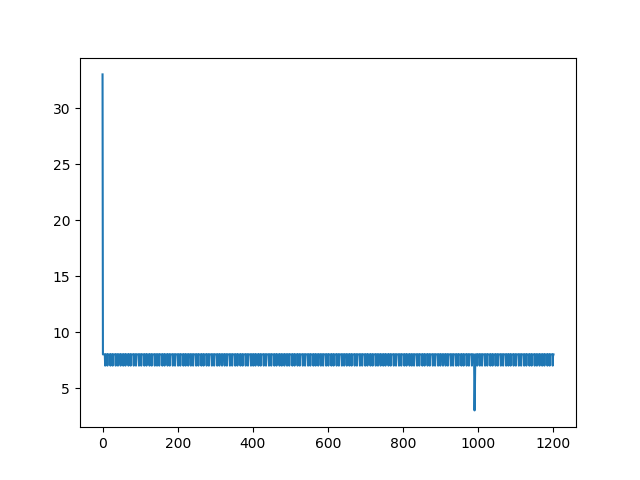

In [6]:
plt.figure()
# rg = np.concatenate((np.arange(1,991),np.arange(992,frm.shape[0])))
plt.plot(np.diff(frm))

In [18]:
trialwise,ctrialwise,strialwise = gen_trialwise()

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.678614382578
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-0.97632220019
-0.877692850455
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.21053181505
-1.0
-1.0
-1.0
-0.582494901679
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1

In [19]:
# frame = matfile['frame']
# traces = matfile['traces']
# stimParams = matfile['stimParams']
# frame = matfile['frame']
# traces = matfile['corrected']
# stimParams = matfile['stimParams']
stimlen = np.diff(frame.reshape((-1,2)),axis=1).min()

In [20]:
def trialize(traces,frame,extra_before=8,extra_after=15):
    fr = frame.reshape((-1,2))
    stimlen = np.diff(fr,axis=1).min()
    ncell = traces.shape[0]
    ntrial = fr.shape[0]
    trialwise = np.zeros((ncell,ntrial,stimlen+extra_before+extra_after))
    for i in range(ntrial):
        trialwise[:,i] = traces[:,fr[i,0]-extra_before:fr[i,0]+stimlen+extra_after]
    return trialwise

In [21]:
extra_before=8
extra_after=15
trialwise = trialize(traces,frame,extra_before=extra_before,extra_after=extra_after)

ValueError: could not broadcast input array from shape (651,0) into shape (651,34)

In [22]:
pwd

'/home/mossing/Documents/notebooks/figure_ground'

In [23]:
def norm01(arr):
    return (arr-arr.min(1)[:,np.newaxis])/(arr.max(1)[:,np.newaxis]-arr.min(1)[:,np.newaxis])

In [24]:
order = ['ctrl','fig','grnd','iso','cross']
ori = stimParams[0]
sz = stimParams[1]
figContrast = stimParams[-2]
grndContrast = stimParams[-1]

paramdict = {}
paramdict['ctrl'] = np.logical_and(figContrast==0,grndContrast==0)
paramdict['fig'] = np.logical_and(figContrast==1,grndContrast==0)
paramdict['grnd'] = np.logical_and(np.logical_and(figContrast==0,grndContrast==1),sz>0)
paramdict['iso'] = sz==0
paramdict['cross'] = np.logical_and(figContrast==1,grndContrast==1)

In [25]:
(np.isnan(traces)).sum()

0

In [26]:
def zscore(trialwise):
    arr = trialwise.reshape((trialwise.shape[0],trialwise.shape[1]*trialwise.shape[2]))
    arr = (arr-arr.mean(1)[:,np.newaxis])/arr.std(1)[:,np.newaxis]
    return arr.reshape(trialwise.shape)

In [27]:
zstrialwise = sst.zscore(strialwise.reshape((strialwise.shape[0],-1)).T).T.reshape(strialwise.shape)

In [28]:
zstrialwise.min()

-0.48014290821831757

<IPython.core.display.Javascript object>


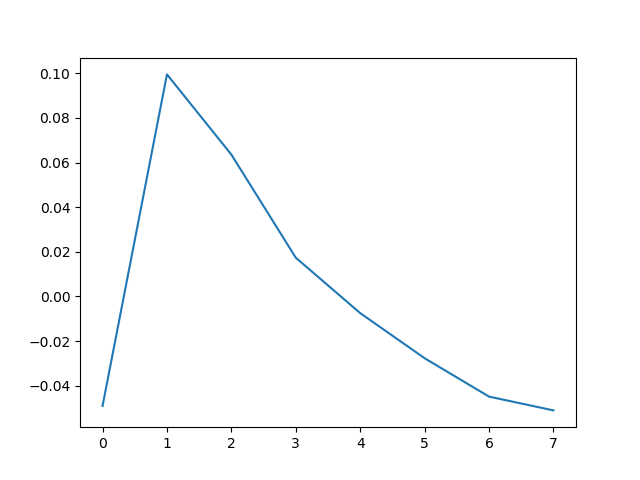

In [29]:
plt.figure()
plt.plot(zstrialwise.mean(0).mean(0))

In [30]:
# orilist = np.unique(ori)
# nori = len(orilist)
# # dimensions are cell X other fig/gd/etc. X orientation X rep no X time
# resp = np.zeros((zs.shape[0],5,nori,5,zs.shape[-1]))
# for i,name in enumerate(order):
#     for j,angle in enumerate(orilist):
#         resp[:,i,j,:,:] = zs[:,np.logical_and(ori==angle,paramdict[name]),:]

In [31]:
zstrialwise.shape

(651, 600, 8)

In [32]:
orilist = np.unique(ori)
nori = len(orilist)
# dimensions are cell X other fig/gd/etc. X orientation X rep no X time
resp = np.zeros((strialwise.shape[0],5,nori,15,strialwise.shape[-1]))
for i,name in enumerate(order):
    for j,angle in enumerate(orilist):
        resp[:,i,j,:,:] = zstrialwise[:,np.logical_and(ori==angle,paramdict[name]),:]

In [33]:
# def print_multipage(t,arr,fn,filename):
#     from matplotlib.backends.backend_pdf import PdfPages
#     plt.close()
#     with PdfPages(filename+'.pdf') as pdf:
#         for i in range(arr.shape[0]):
#             fn(t,arr[i])
#             pdf.savefig()
#             plt.close()

In [34]:
t = np.arange(-extra_before,stimlen+extra_after)/(15.5/2)

In [35]:
def fill_in_sem(t,arr,c='b'):
    mn = arr.mean(0)
    sem = arr.std(0)/np.sqrt(arr.shape[0])
    squiggle = plt.fill_between(t,mn-sem,mn+sem,facecolor=c,alpha=0.5)
    return squiggle

In [36]:
def plotZs(t,arr):
    for i in range(8):
        plt.subplot(3,4,i+1)
        ishift = np.remainder(i-2,8)
        squig_fig = fill_in_sem(t,arr[1,i],c='b')
        squig_ground = fill_in_sem(t,arr[2,ishift],c='g')
        squig_iso = fill_in_sem(t,arr[3,ishift],c='m')
        squig_cross = fill_in_sem(t,arr[4,i],c='c')
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        plt.ylim((arr.mean(3).min()-arr.std(3).max(),arr.mean(3).max()+arr.std(3).max()))
    plt.subplot(3,4,12)
    plt.axis('off')
    plt.legend((squig_fig,squig_ground,squig_iso,squig_cross),('figure only','ground only','iso','cross'))

In [37]:
fig_responsive = (resp[:,1].mean(1).mean(1)-resp[:,1].mean(1).std(1)/np.sqrt(40)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
grnd_responsive = (resp[:,2].mean(1).mean(1)-resp[:,2].mean(1).std(1)/np.sqrt(40)).max(1)>(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
lkat = np.logical_and(fig_responsive,~grnd_responsive)

In [38]:
resp[lkat].shape

(109, 5, 8, 15, 8)

In [39]:
with h5py.File(datafold+datafiles[1],mode='r') as f:
    trialrun = f['trialrun'][:].T

KeyError: "Unable to open object (Object 'trialrun' doesn't exist)"

<IPython.core.display.Javascript object>


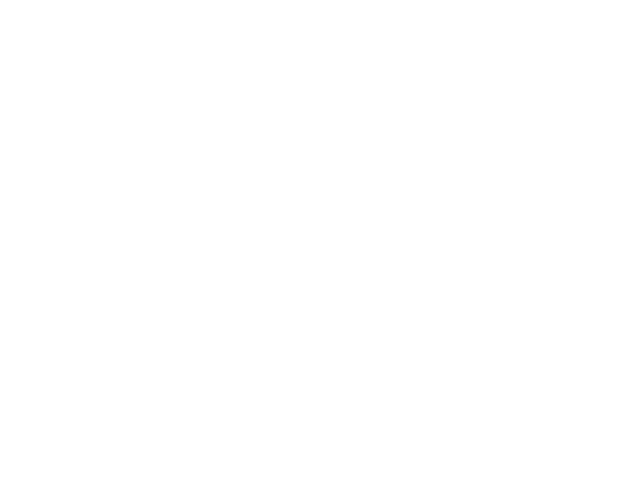

NameError: name 'trialrun' is not defined

In [40]:
plt.figure()
plt.hist(trialrun.mean(1),bins=50)

In [44]:
plt.figure(figsize=(12,10))
for i in range(lkat.sum()):
    plt.subplot(5,6,i+1)
    plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='k')

<IPython.core.display.Javascript object>

/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/home/mossing/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/home/mossing/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


ValueError: num must be 1 <= num <= 30, not 31

In [41]:
# plt.figure(figsize=(12,10))
# for i in range(lkat.sum()):
#     plt.subplot(5,6,i+1)
#     plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
#     plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1),alpha=0.3,c='m')
#     plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1),alpha=0.3,c='g')
#     plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1),alpha=0.3,c='k')
plt.figure(figsize=(12,10))
for i in range(lkat.sum()):
    plt.subplot(4,10,i+1)
    plt.plot(resp[lkat][i,1].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3].mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4].mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2].mean(-1),alpha=0.3,c='k')

<IPython.core.display.Javascript object>

ValueError: num must be 1 <= num <= 40, not 41

<IPython.core.display.Javascript object>


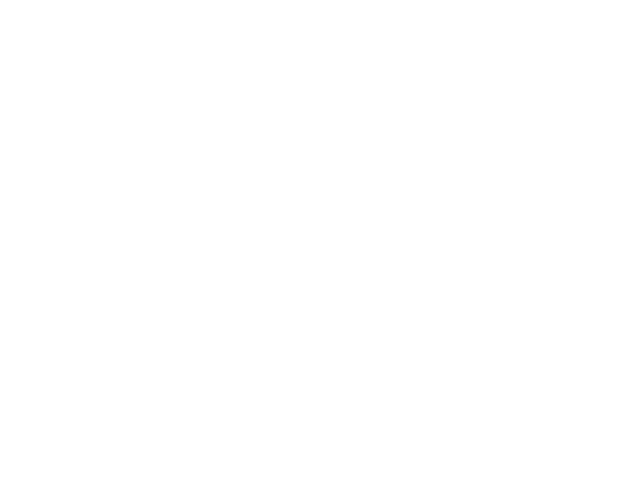

<IPython.core.display.Javascript object>


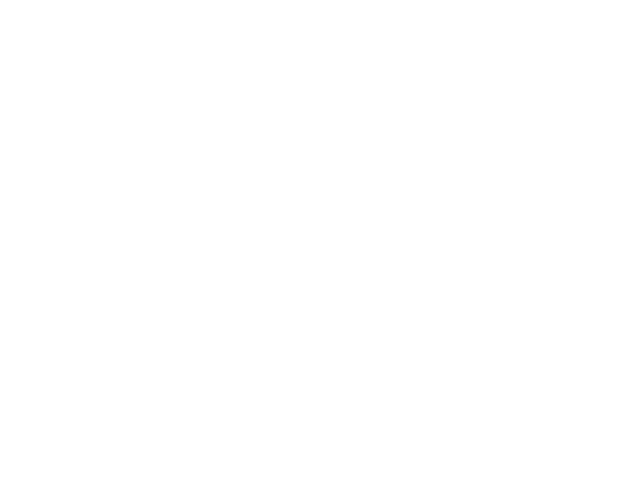

<IPython.core.display.Javascript object>


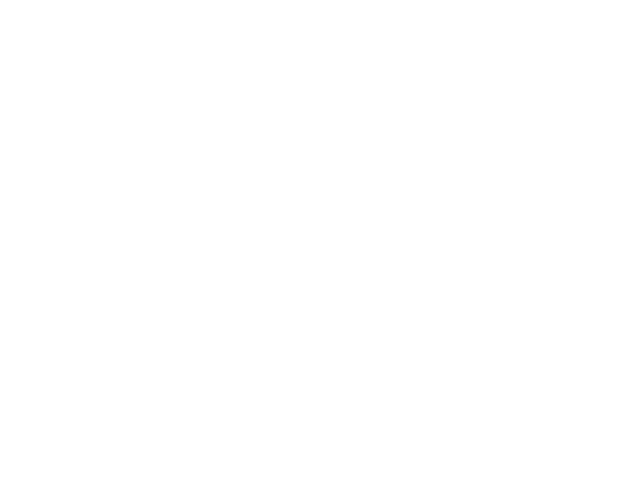

<IPython.core.display.Javascript object>


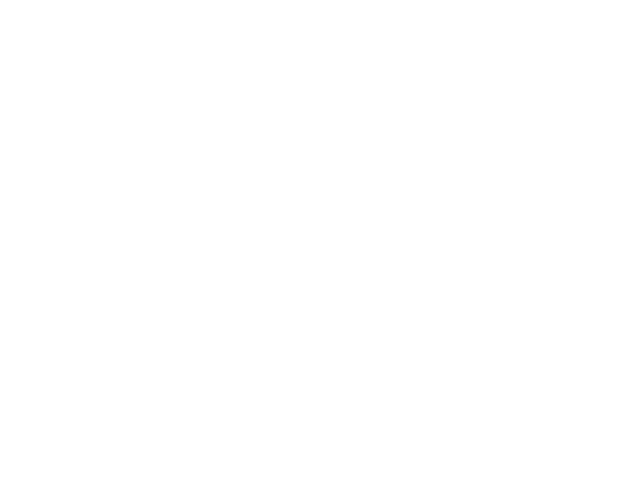

<IPython.core.display.Javascript object>


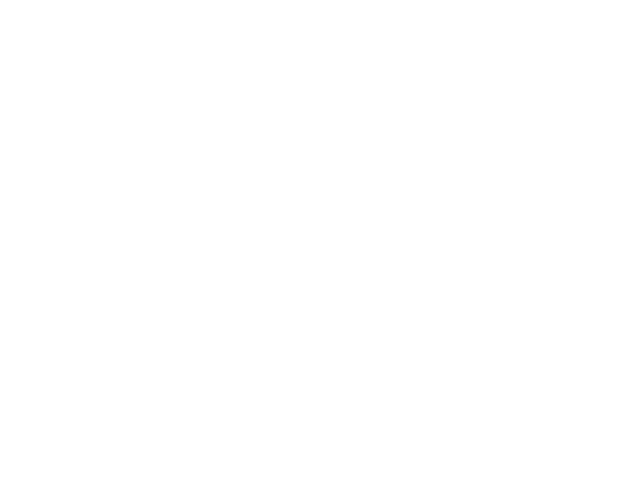

<IPython.core.display.Javascript object>


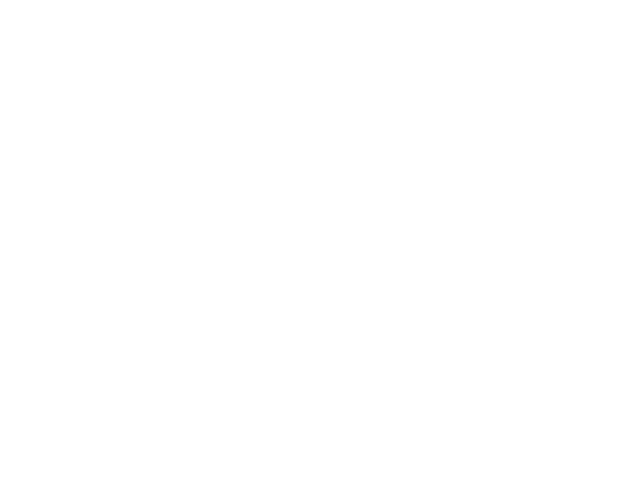

<IPython.core.display.Javascript object>


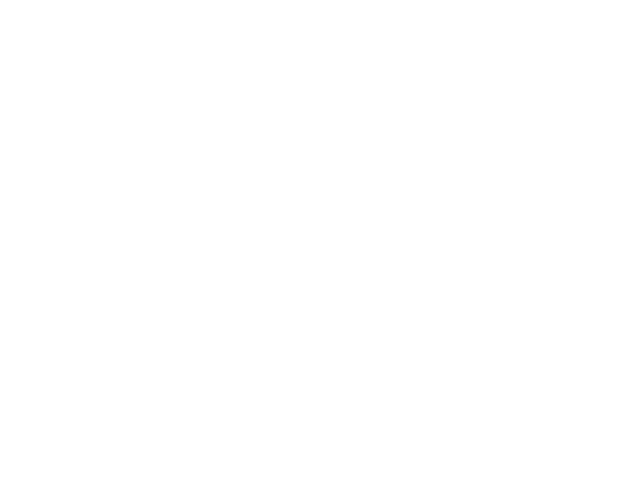

<IPython.core.display.Javascript object>


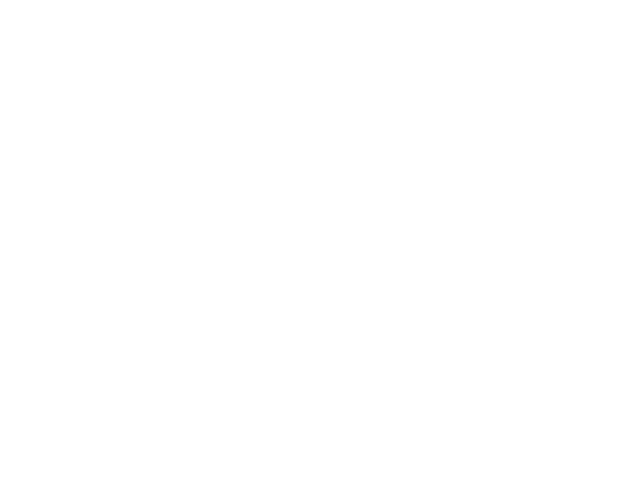

<IPython.core.display.Javascript object>


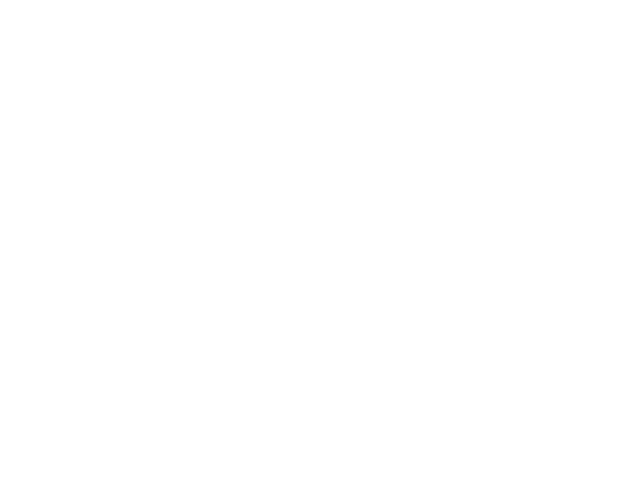

<IPython.core.display.Javascript object>


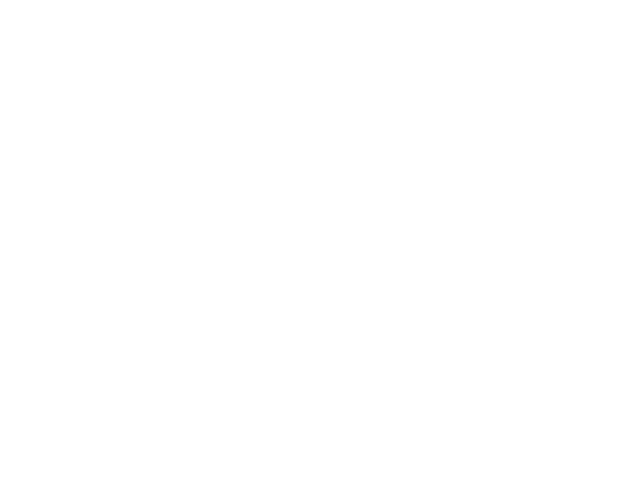

<IPython.core.display.Javascript object>


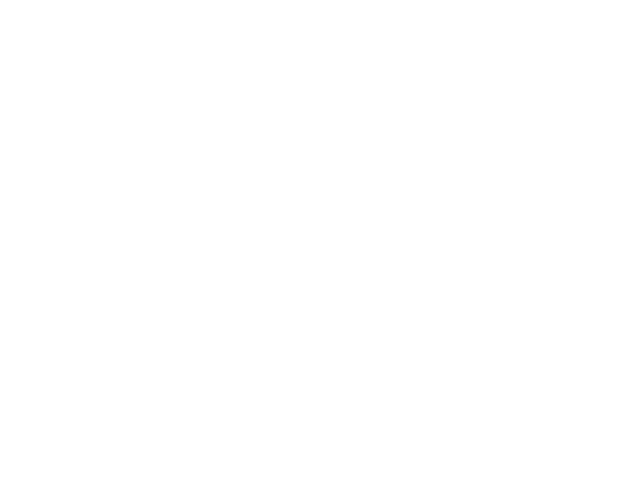

<IPython.core.display.Javascript object>


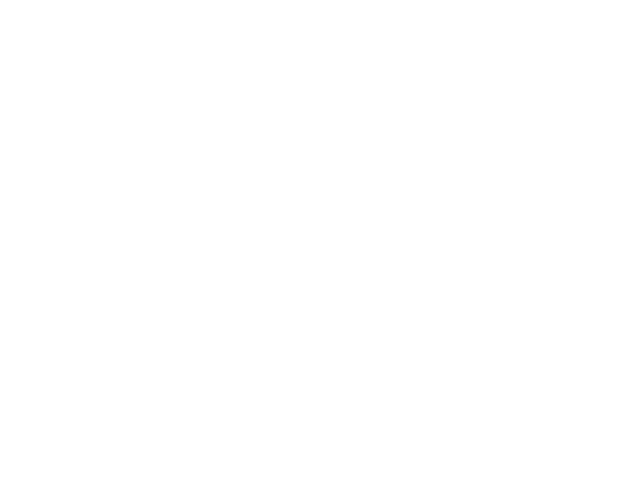

<IPython.core.display.Javascript object>


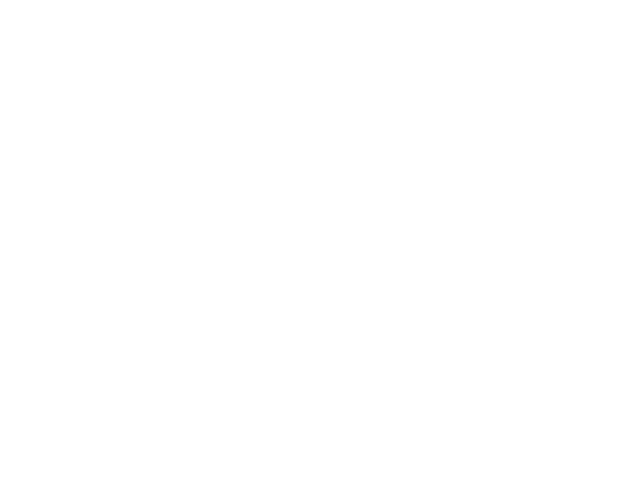

<IPython.core.display.Javascript object>


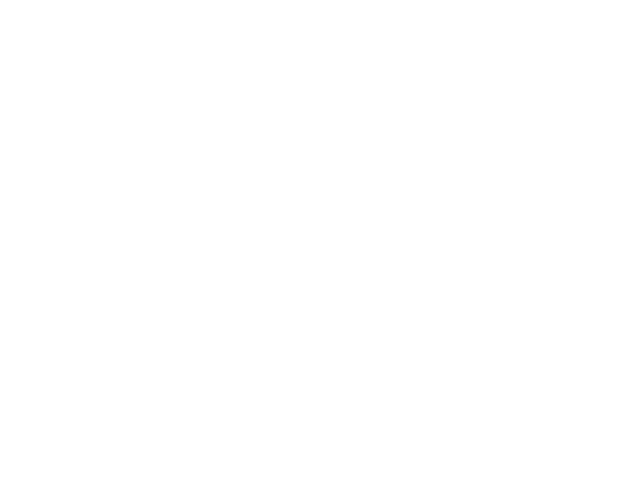

<IPython.core.display.Javascript object>


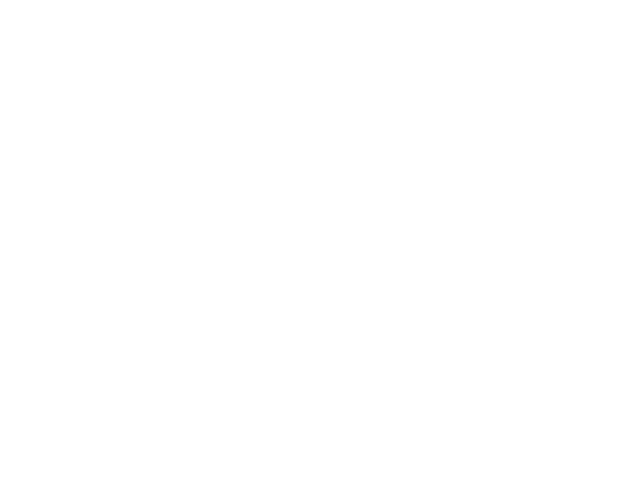

<IPython.core.display.Javascript object>


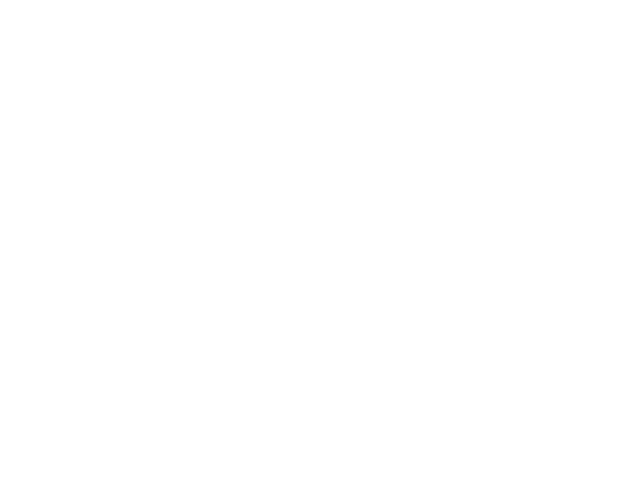

<IPython.core.display.Javascript object>


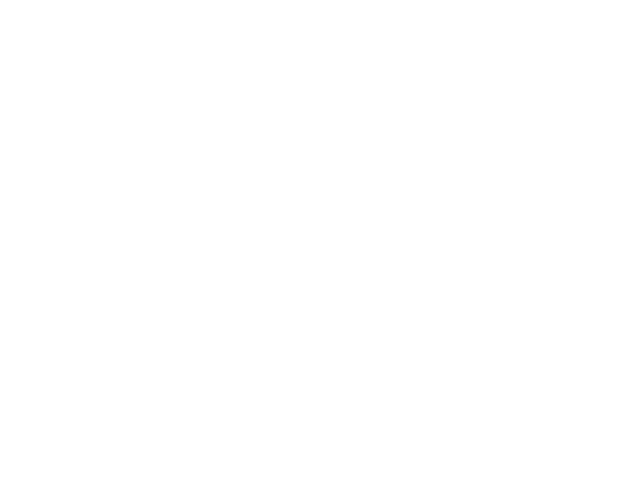

<IPython.core.display.Javascript object>


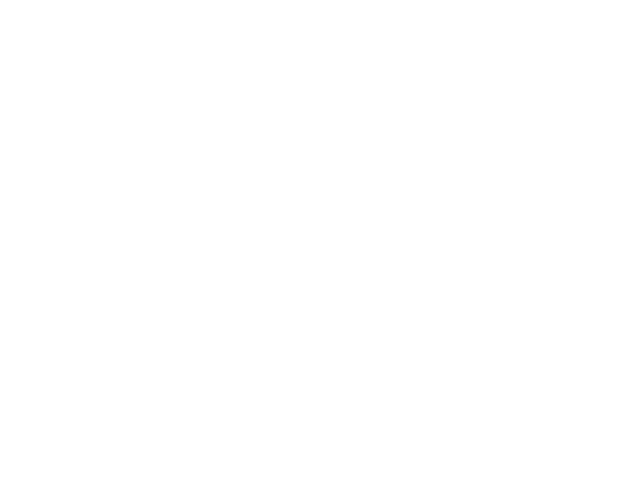

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [22]:
# print_multipage(t,resp[lkat],plotZs,'fig_responsive')

In [ ]:
peakinds = np.argmax(sfi.gaussian_filter(resp[:,4],sigma=(0,0,0,2)).mean(1).mean(1),axis=1)
order_by_peak = np.argsort(peakinds)
peaksort = peakinds[order_by_peak]

In [42]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

In [43]:
resp.shape

(651, 5, 8, 15, 8)

In [44]:
lkat.sum()

109

In [114]:
mx = np.nanmax(np.nanmax(strialwise,axis=1),axis=1)
avgresp = resp[lkat].mean(2).mean(2).mean(-1) #/mx[lkat,np.newaxis]

In [124]:
matdict = {}
matdict['dataX'] = avgresp[:,-2]
matdict['dataY'] = avgresp[:,-1]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate iso-oriented'
matdict['labelY'] = 'z-scored event rate cross-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('pc_iso_cross_180327.mat',matdict)

In [125]:
matdict = {}
matdict['dataX'] = avgresp[:,1]
matdict['dataY'] = avgresp[:,3]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate center only'
matdict['labelY'] = 'z-scored event rate iso-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('pc_center_iso_180327.mat',matdict)

<IPython.core.display.Javascript object>


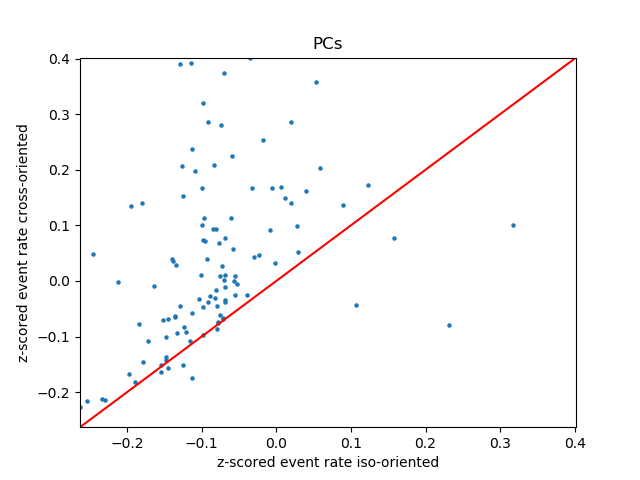

Text(0.5,1,'PCs')

In [123]:
plt.figure()
plt.scatter(avgresp[:,-2],avgresp[:,-1],s=5)
mxm = np.maximum(avgresp[:,-2].max(),avgresp[:,-1].max())
mnm = np.minimum(avgresp[:,-2].min(),avgresp[:,-1].min())
plt.plot((mnm,mxm),(mnm,mxm),c='r')
plt.xlim((mnm,mxm))
plt.ylim((mnm,mxm))
plt.xlabel('z-scored event rate iso-oriented')
plt.ylabel('z-scored event rate cross-oriented')
plt.title('PCs')
# plt.savefig('pc_iso_cross.eps')

<IPython.core.display.Javascript object>


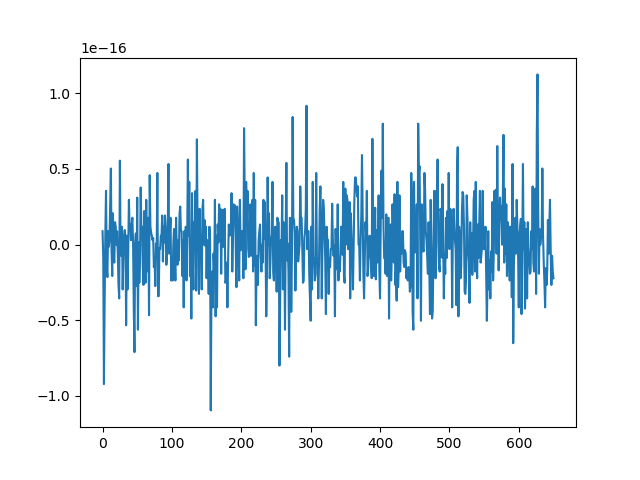

In [64]:
plt.figure()
plt.plot(np.nanmean(zstrialwise.reshape(zstrialwise.shape[0],-1),axis=1))

In [108]:
R = np.random.rand(1000,10000)
for i in range(R.shape[0]):
    R[i] = R[i]*(i+101)
R = np.exp(-R)
Rfinal = 0.01*np.random.randn(1000,10000) + R
Rz = sst.zscore(R.T).T

In [111]:
R.max(1).std()

0.060182217237499037

<IPython.core.display.Javascript object>


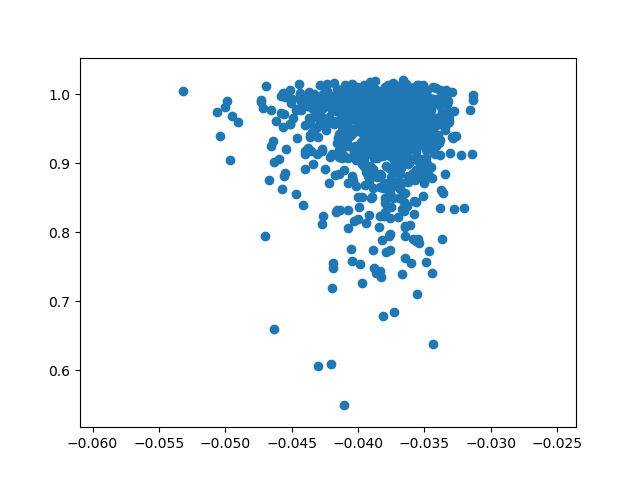

In [113]:
plt.figure()
plt.scatter(Rfinal.min(axis=1),Rfinal.max(axis=1))
# plt.hist(R[0],50)

<IPython.core.display.Javascript object>


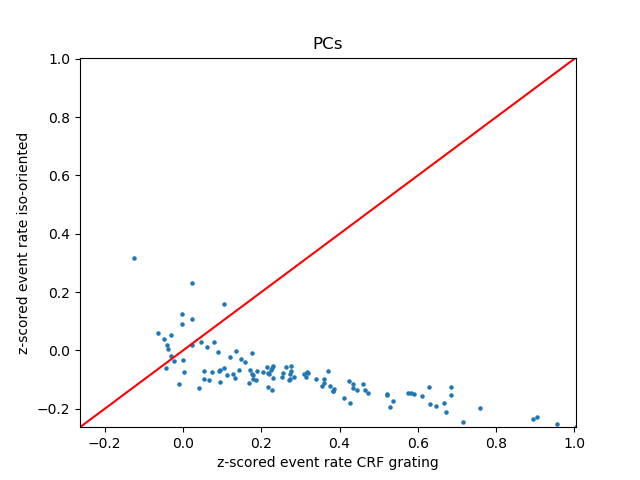

In [122]:
plt.figure()
plt.scatter(avgresp[:,1],avgresp[:,3],s=5)
mxm = np.maximum(avgresp[:,1].max(),avgresp[:,3].max())
mnm = np.minimum(avgresp[:,1].min(),avgresp[:,3].min())
plt.plot((mnm,mxm),(mnm,mxm),c='r')
plt.xlim((mnm,mxm))
plt.ylim((mnm,mxm))
plt.xlabel('z-scored event rate CRF grating')
plt.ylabel('z-scored event rate iso-oriented')
plt.title('PCs')
plt.savefig('pc_iso_cross.eps')

In [38]:
isresponsive = fig_responsive = (resp[:,1:5].mean(1).mean(1).mean(1)-resp[:,1:5].mean(1).mean(1).std(1)/np.sqrt(160)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)

In [39]:
isresponsive.sum()

408

In [40]:
avgresp = resp[:,1:4].mean(1).mean(1).mean(1)

In [41]:
plt.imshow(norm01(avgresp[order_by_peak[isresponsive]]),interpolation='nearest',cmap=plt.cm.viridis)

In [30]:
ontarget = resp[lkat].mean(-1)
ontarget = ontarget[:,1:]-ontarget[:,0:1]

In [31]:
gd = np.where(isresponsive)[0]

In [32]:
tracez = (traces-traces.mean(1)[:,np.newaxis])/traces.std(1)[:,np.newaxis]

In [33]:
np.outer(isresponsive,paramdict['cross']).shape

(79, 200)

In [37]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
mx = np.maximum(Ccross.max(),Cfig.max())
mn = np.maximum(Ccross.min(),Cfig.min())

<IPython.core.display.Javascript object>


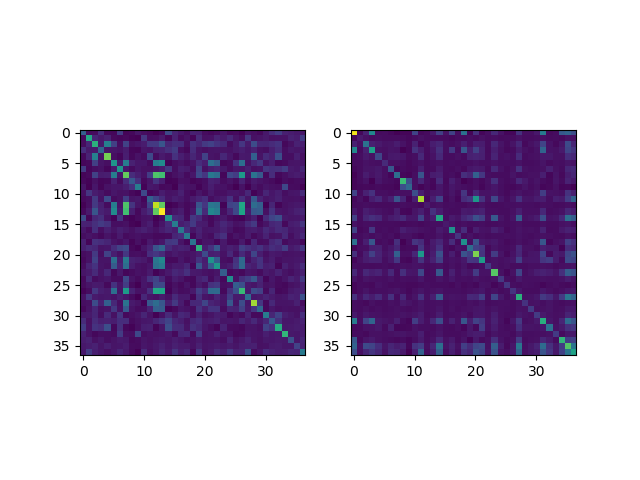

In [40]:
plt.subplot(1,2,1)
plt.imshow(Ccross,vmax=mx,vmin=mn)
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Cfig,vmax=mx,vmin=mn)
# plt.colorbar()

In [351]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
Cgrnd = np.cov(zs[isresponsive][:,paramdict['grnd']].reshape((isresponsive.sum(),-1)))
Ciso = np.cov(zs[isresponsive][:,paramdict['iso']].reshape((isresponsive.sum(),-1)))
ucross,scross,vcross = np.linalg.svd(Ccross)
ufig,sfig,vfig = np.linalg.svd(Cfig)
ugrnd,sgrnd,vgrnd = np.linalg.svd(Cgrnd)
uiso,siso,viso = np.linalg.svd(Ciso)

In [391]:
popvec = resp[isresponsive].mean(4)
popvec = popvec = popvec/np.linalg.norm(popvec,axis=0)

<IPython.core.display.Javascript object>


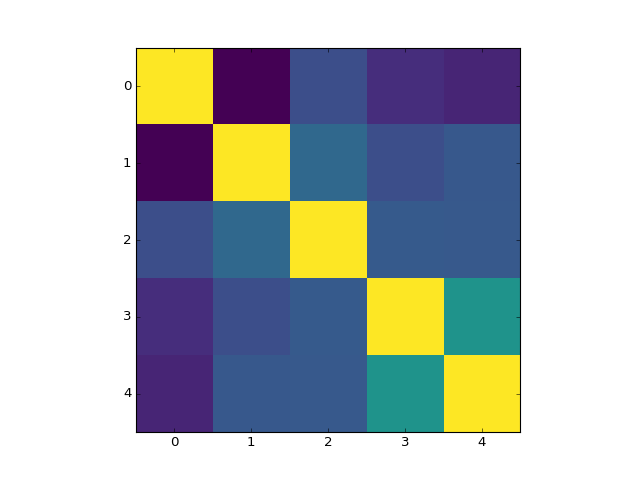

In [414]:
j = 4
k = 6
plt.imshow(np.dot(popvec[:,j,k,:].T,popvec[:,j,k,:]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)

<IPython.core.display.Javascript object>


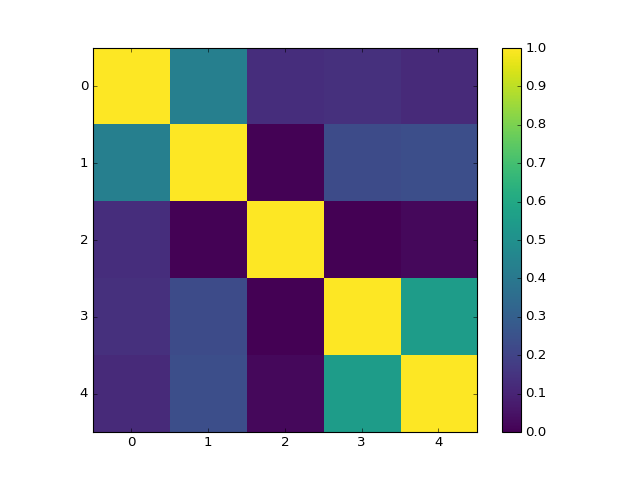

In [389]:
plt.imshow(np.abs(D[:20,:20]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


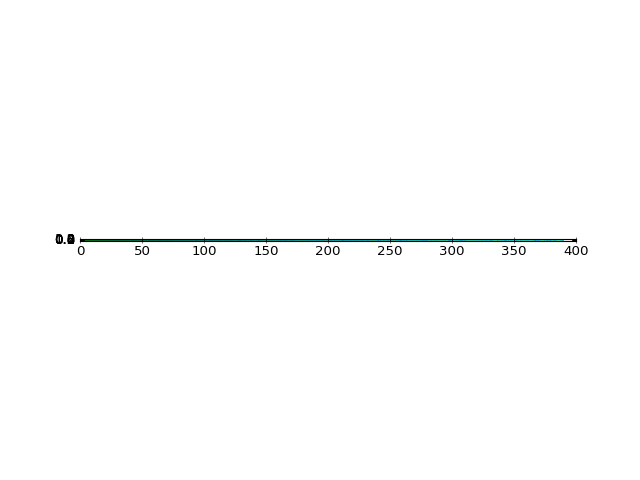

In [332]:
plt.plot(np.cumsum(scross/scross.sum()))
plt.plot(np.cumsum(sfig/sfig.sum()))

<IPython.core.display.Javascript object>


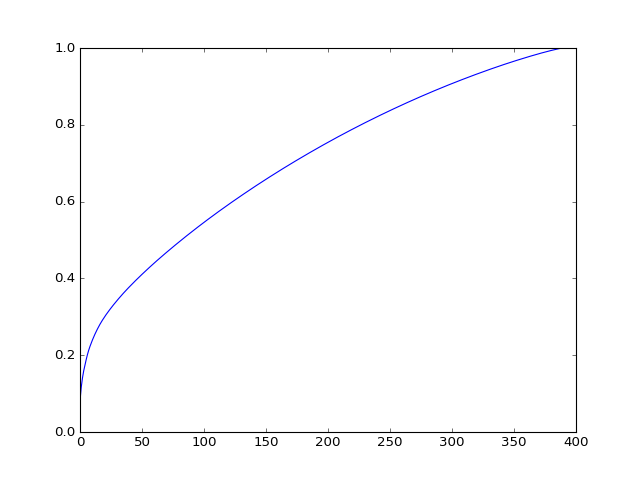

In [313]:
plt.plot(np.cumsum(s/s.sum()))

In [245]:
lincross = ontarget[:,0]+ontarget[:,1]
cross = ontarget[:,3]
liniso = ontarget[:,0]+ontarget[:,1,np.append(np.arange(6,8),np.arange(0,6))]
iso = ontarget[:,2]

<IPython.core.display.Javascript object>


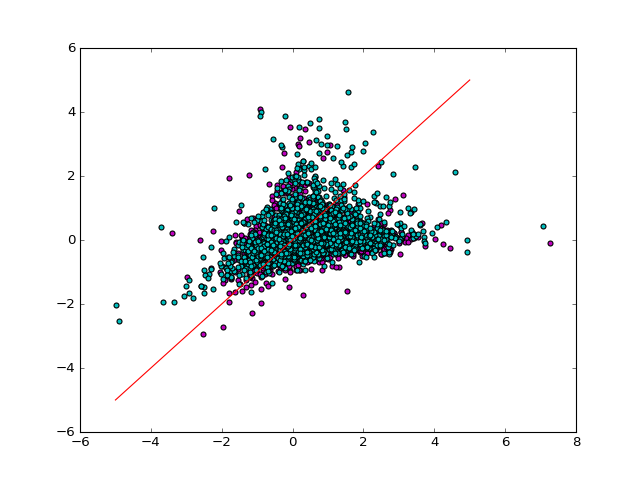

In [252]:
plt.scatter(liniso.flatten(),iso.flatten(),c='m')
plt.scatter(lincross.flatten(),cross.flatten(),c='c')
plt.plot((-5,5),(-5,5),c='r')

<IPython.core.display.Javascript object>


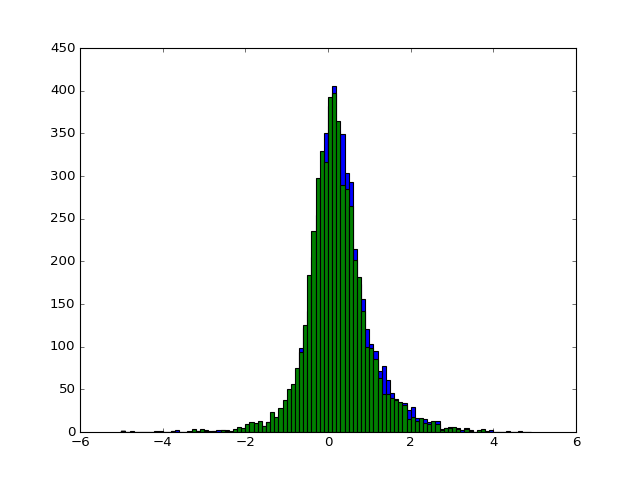

In [284]:
hiso = plt.hist(liniso.flatten()-iso.flatten(),bins=np.arange(-5,5,0.1))
hcross = plt.hist(lincross.flatten()-cross.flatten(),bins=np.arange(-5,5,0.1))

<IPython.core.display.Javascript object>


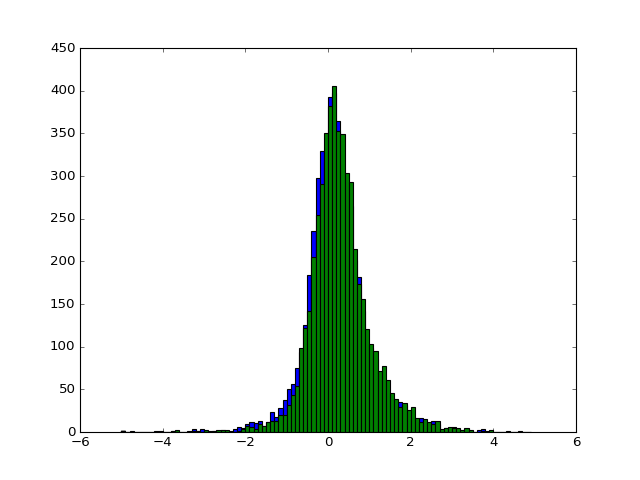

In [278]:
hiso[0].shape

(99,)

In [279]:
np.arange(-5,5,0.1).shape

(100,)